In [16]:
# =========================
# TCN
# =========================
!pip install keras-tcn -q



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


# new code

In [ ]:
# -----------------------
# Block 1: Preprocessing
# -----------------------
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import joblib

# Load data (update paths if needed)
df_1 = pd.read_csv("Data_in_France/time_series.csv")
df_2 = pd.read_csv("Data_in_France/weather_data.csv")

# Merge
df = pd.merge(df_1, df_2, on='utc_timestamp')

# Datetime index
df['utc_timestamp'] = pd.to_datetime(df['utc_timestamp'])
df.set_index('utc_timestamp', inplace=True)

In [ ]:

# Drop unwanted cols if present
for col in ['FR_load_forecast_entsoe_transparency', 'FR_load_actual_entsoe_transparency', 'cet_cest_timestamp']:
    if col in df.columns:
        df.drop(col, axis=1, inplace=True)

# Add temporal features (cyclical)
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['month'] = df.index.month
# cyclical encodings
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['dow_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
df['dow_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)
df['month_sin'] = np.sin(2 * np.pi * (df['month']-1) / 12)
df['month_cos'] = np.cos(2 * np.pi * (df['month']-1) / 12)


In [ ]:


# Drop rows with NaNs
df.dropna(inplace=True)

# TARGET and FEATURES
TARGET_COL = 'FR_solar_generation_actual'
FEATURE_COLS = [c for c in df.columns if c != TARGET_COL]

# Clip negative solar to zero (prevents -inf in log)
y_raw = df[TARGET_COL].values
y_raw = np.clip(y_raw, 0, None)

# log1p transform target to stabilize variance
y_log = np.log1p(y_raw).reshape(-1, 1)


In [ ]:

# Feature matrix
X = df[FEATURE_COLS].values


In [ ]:

# Scale features and target (store scalers)
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y_log)

In [ ]:


joblib.dump(scaler_X, 'scaler_X.joblib')
joblib.dump(scaler_y, 'scaler_y.joblib')

print("Preprocessing done. X shape:", X_scaled.shape, "y shape:", y_scaled.shape)


# Block 2: Sequences & splits

In [ ]:
# -----------------------
# Block 2: Sequences & splits
# -----------------------
import numpy as np
LOOKBACK = 168

def create_sequences(X, y, lookback=LOOKBACK):
    Xs, ys = [], []
    for i in range(lookback, len(X)):
        Xs.append(X[i-lookback:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X_scaled, y_scaled, LOOKBACK)
print("Sequences created:", X_seq.shape, y_seq.shape)


In [ ]:

n = len(X_seq)
train_end = int(0.7 * n)
val_end = int(0.85 * n)

X_train = X_seq[:train_end]
y_train = y_seq[:train_end]
X_val = X_seq[train_end:val_end]
y_val = y_seq[train_end:val_end]
X_test = X_seq[val_end:]
y_test = y_seq[val_end:]

print("Train/Val/Test shapes:", X_train.shape, X_val.shape, X_test.shape)


In [ ]:
# For later metric computation prepare the inverse-target of test set (raw MW)
import joblib
scaler_y = joblib.load('scaler_y.joblib')

In [5]:


# y_test_inv_raw: inverse transform then expm1 to undo log1p
y_test_inv = np.expm1(scaler_y.inverse_transform(y_test.reshape(-1,1)))
print("Example target raw MW stats on test set:", np.nanmin(y_test_inv), np.nanmax(y_test_inv), np.nanmean(y_test_inv))


Sequences created: (34885, 168, 17) (34885, 1)
Train/Val/Test shapes: (24419, 168, 17) (5233, 168, 17) (5233, 168, 17)
Example target raw MW stats on test set: 0.0 5016.0 1018.333651824957


# Block 3: 1D-CNN

In [ ]:
# -----------------------
# Block 3: 1D-CNN
# -----------------------
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
n_features = X_train.shape[2]

cnn = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(LOOKBACK, n_features)),
    BatchNormalization(),
    MaxPooling1D(2),
    Conv1D(32, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(2),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.3),
    Dense(1)
])


In [ ]:

cnn.compile(optimizer=Adam(1e-3), loss='mse', metrics=['mae'])
cnn.summary()

es = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, min_lr=1e-6, verbose=1)

In [24]:




history_cnn = cnn.fit(X_train, y_train, validation_data=(X_val, y_val),
                      epochs=80, batch_size=128, callbacks=[es, rlr], verbose=1)

# predictions: inverse + expm1
y_pred_cnn = cnn.predict(X_test)
y_pred_cnn_inv = np.expm1(scaler_y.inverse_transform(y_pred_cnn.reshape(-1,1)))
y_pred_cnn_inv = np.clip(y_pred_cnn_inv, 0, None)

# Mask day-time > 10 MW for reliable MAPE
mask = (y_test_inv.flatten() > 10)

mae_cnn = mean_absolute_error(y_test_inv[mask], y_pred_cnn_inv[mask])
rmse_cnn = np.sqrt(mean_squared_error(y_test_inv[mask], y_pred_cnn_inv[mask]))
mape_cnn = np.mean(np.abs((y_test_inv[mask] - y_pred_cnn_inv[mask]) / y_test_inv[mask])) * 100

print(f"1D-CNN | MAE: {mae_cnn:.2f} MW | RMSE: {rmse_cnn:.2f} MW | Masked MAPE: {mape_cnn:.2f}%")


d:\deepleanring project\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 166, 64)        │         3,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 166, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 83, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 81, 32)         │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 81, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 40, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 173,985 (679.63 KB)

 Trainable params: 173,793 (678.88 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/80
191/191 ━━━━━━━━━━━━━━━━━━━━ 17s 42ms/step - loss: 0.5849 - mae: 0.3832 - val_loss: 3.0815 - val_mae: 1.6820 - learning_rate: 0.0010
Epoch 2/80
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - loss: 0.2143 - mae: 0.1064 - val_loss: 0.2765 - val_mae: 0.2585 - learning_rate: 0.0010
Epoch 3/80
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.1827 - mae: 0.0810 - val_loss: 0.1696 - val_mae: 0.0767 - learning_rate: 0.0010
Epoch 4/80
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - loss: 0.1577 - mae: 0.0715 - val_loss: 0.1460 - val_mae: 0.0689 - learning_rate: 0.0010
Epoch 5/80
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - loss: 0.1357 - mae: 0.0683 - val_loss: 0.1261 - val_mae: 0.0689 - learning_rate: 0.0010
Epoch 6/80
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.1157 - mae: 0.0656 - val_loss: 0.1044 - val_mae: 0.0552 - learning_rate: 0.0010
Epoch 7/80
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.0975 - mae: 0.0634 - val_loss: 0.0885 - val_mae: 0.0566 - learning_rate: 0.001

# Block 4: LSTM (your architecture, with L2, BN, Dropout)

In [ ]:
# -----------------------
# Block 4: LSTM (your architecture, with L2, BN, Dropout)
# -----------------------
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:

lstm = Sequential([
    LSTM(64, return_sequences=True, input_shape=(LOOKBACK, n_features), kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.25),
    LSTM(32, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.25),
    Dense(16, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(1)
])

In [ ]:
lstm.compile(optimizer=Adam(1e-4), loss='mse', metrics=['mae'])
lstm.summary()

es_l = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True, verbose=1)
rlr_l = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, min_lr=1e-7, verbose=1)

In [26]:
history_lstm = lstm.fit(X_train, y_train, validation_data=(X_val, y_val),
                        epochs=80, batch_size=64, callbacks=[es_l, rlr_l], verbose=1)

y_pred_lstm = lstm.predict(X_test)
y_pred_lstm_inv = np.expm1(scaler_y.inverse_transform(y_pred_lstm.reshape(-1,1)))
y_pred_lstm_inv = np.clip(y_pred_lstm_inv, 0, None)

mae_lstm = mean_absolute_error(y_test_inv[mask], y_pred_lstm_inv[mask])
rmse_lstm = np.sqrt(mean_squared_error(y_test_inv[mask], y_pred_lstm_inv[mask]))
mape_lstm = np.mean(np.abs((y_test_inv[mask] - y_pred_lstm_inv[mask]) / y_test_inv[mask])) * 100

print(f"LSTM | MAE: {mae_lstm:.2f} MW | RMSE: {rmse_lstm:.2f} MW | Masked MAPE: {mape_lstm:.2f}%")


d:\deepleanring project\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 168, 64)        │        20,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 168, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 168, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,337 (134.13 KB)

 Trainable params: 34,145 (133.38 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/80
382/382 ━━━━━━━━━━━━━━━━━━━━ 86s 193ms/step - loss: 0.9429 - mae: 0.7008 - val_loss: 0.2531 - val_mae: 0.2731 - learning_rate: 1.0000e-04
Epoch 2/80
382/382 ━━━━━━━━━━━━━━━━━━━━ 110s 288ms/step - loss: 0.3785 - mae: 0.3892 - val_loss: 0.2163 - val_mae: 0.2241 - learning_rate: 1.0000e-04
Epoch 3/80
382/382 ━━━━━━━━━━━━━━━━━━━━ 104s 273ms/step - loss: 0.3033 - mae: 0.3282 - val_loss: 0.1896 - val_mae: 0.1861 - learning_rate: 1.0000e-04
Epoch 4/80
382/382 ━━━━━━━━━━━━━━━━━━━━ 117s 307ms/step - loss: 0.2584 - mae: 0.2847 - val_loss: 0.1782 - val_mae: 0.1705 - learning_rate: 1.0000e-04
Epoch 5/80
382/382 ━━━━━━━━━━━━━━━━━━━━ 121s 316ms/step - loss: 0.2248 - mae: 0.2498 - val_loss: 0.1632 - val_mae: 0.1485 - learning_rate: 1.0000e-04
Epoch 6/80
382/382 ━━━━━━━━━━━━━━━━━━━━ 128s 334ms/step - loss: 0.2017 - mae: 0.2238 - val_loss: 0.1497 - val_mae: 0.1299 - learning_rate: 1.0000e-04
Epoch 7/80
382/382 ━━━━━━━━━━━━━━━━━━━━ 110s 287ms/step - loss: 0.1847 - mae: 0.2028 - val_loss: 0.14

# Block 5: TCN (keras-tcn)

In [ ]:
# -----------------------
# Block 5: TCN (keras-tcn)
# -----------------------
# run this cell once to install if not installed:
# !pip install keras-tcn -q

from tcn import TCN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:

# Build TCN: use use_batch_norm inside TCN; no kernel_regularizer in TCN layer
tcn_model = Sequential([
    TCN(nb_filters=64, kernel_size=3, dilations=[1,2,4,8,16], nb_stacks=1,
        return_sequences=True, activation='relu', dropout_rate=0.1, use_batch_norm=True,
        input_shape=(LOOKBACK, n_features)),
    BatchNormalization(),
    Dropout(0.2),
    TCN(nb_filters=32, kernel_size=3, dilations=[1,2,4,8], nb_stacks=1,
        return_sequences=False, activation='relu', dropout_rate=0.1, use_batch_norm=True),
    BatchNormalization(),
    Dropout(0.2),
    Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dense(1)
])

In [ ]:


tcn_model.compile(optimizer=Adam(1e-4), loss='mse', metrics=['mae'])
tcn_model.summary()

es_t = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True, verbose=1)
rlr_t = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, min_lr=1e-7, verbose=1)

In [27]:



history_tcn = tcn_model.fit(X_train, y_train, validation_data=(X_val, y_val),
                            epochs=80, batch_size=64, callbacks=[es_t, rlr_t], verbose=1)

y_pred_tcn = tcn_model.predict(X_test)
y_pred_tcn_inv = np.expm1(scaler_y.inverse_transform(y_pred_tcn.reshape(-1,1)))
y_pred_tcn_inv = np.clip(y_pred_tcn_inv, 0, None)


d:\deepleanring project\venv\Lib\site-packages\tcn\tcn.py:268: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ tcn_4 (TCN)                     │ (None, 168, 64)        │       118,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 168, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 168, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tcn_5 (TCN)                     │ (None, 32)             │        31,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_43          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 150,689 (588.63 KB)

 Trainable params: 148,705 (580.88 KB)

 Non-trainable params: 1,984 (7.75 KB)

Epoch 1/80
382/382 ━━━━━━━━━━━━━━━━━━━━ 130s 277ms/step - loss: 0.5226 - mae: 0.5458 - val_loss: 0.1738 - val_mae: 0.3180 - learning_rate: 1.0000e-04
Epoch 2/80
382/382 ━━━━━━━━━━━━━━━━━━━━ 96s 249ms/step - loss: 0.2938 - mae: 0.4081 - val_loss: 0.1326 - val_mae: 0.2674 - learning_rate: 1.0000e-04
Epoch 3/80
382/382 ━━━━━━━━━━━━━━━━━━━━ 116s 302ms/step - loss: 0.2159 - mae: 0.3435 - val_loss: 0.1013 - val_mae: 0.2214 - learning_rate: 1.0000e-04
Epoch 4/80
382/382 ━━━━━━━━━━━━━━━━━━━━ 98s 257ms/step - loss: 0.1699 - mae: 0.2986 - val_loss: 0.0828 - val_mae: 0.1891 - learning_rate: 1.0000e-04
Epoch 5/80
382/382 ━━━━━━━━━━━━━━━━━━━━ 86s 226ms/step - loss: 0.1373 - mae: 0.2622 - val_loss: 0.0699 - val_mae: 0.1635 - learning_rate: 1.0000e-04
Epoch 6/80
382/382 ━━━━━━━━━━━━━━━━━━━━ 87s 227ms/step - loss: 0.1133 - mae: 0.2314 - val_loss: 0.0600 - val_mae: 0.1419 - learning_rate: 1.0000e-04
Epoch 7/80
382/382 ━━━━━━━━━━━━━━━━━━━━ 91s 239ms/step - loss: 0.0958 - mae: 0.2063 - val_loss: 0.0537 -

TypeError: got an unexpected keyword argument 'squared'

In [28]:

mae_tcn = mean_absolute_error(y_test_inv[mask], y_pred_tcn_inv[mask])
rmse_tcn = np.sqrt(mean_squared_error(y_test_inv[mask], y_pred_tcn_inv[mask]))
mape_tcn = np.mean(np.abs((y_test_inv[mask] - y_pred_tcn_inv[mask]) / y_test_inv[mask])) * 100

print(f"TCN | MAE: {mae_tcn:.2f} MW | RMSE: {rmse_tcn:.2f} MW | Masked MAPE: {mape_tcn:.2f}%")


TCN | MAE: 613.33 MW | RMSE: 836.50 MW | Masked MAPE: 32.03%


# Block 6: Transformer

In [ ]:
# -----------------------
# Block 6: Transformer
# -----------------------
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, Add, Embedding
from tensorflow.keras.models import Model
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [ ]:

def get_positional_encoding(seq_len, dim):
    pos = np.arange(seq_len)[:, np.newaxis]
    i = np.arange(dim)[np.newaxis, :]
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(dim))
    angle_rads = pos * angle_rates
    pe = np.zeros((seq_len, dim))
    pe[:, 0::2] = np.sin(angle_rads[:, 0::2])
    pe[:, 1::2] = np.cos(angle_rads[:, 1::2])
    return tf.cast(pe, dtype=tf.float32)


In [ ]:

def transformer_encoder(inputs, head_size=64, num_heads=4, ff_dim=128, dropout=0.2):
    # MultiHeadAttention
    x = LayerNormalization(epsilon=1e-6)(inputs)
    attn = MultiHeadAttention(num_heads=num_heads, key_dim=head_size, dropout=dropout)(x, x)
    attn = Dropout(dropout)(attn)
    x = Add()([x, attn])
    x = LayerNormalization(epsilon=1e-6)(x)
    ff = Dense(ff_dim, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    ff = Dropout(dropout)(ff)
    ff = Dense(inputs.shape[-1], kernel_regularizer=tf.keras.regularizers.l2(0.001))(ff)
    x = Add()([x, ff])
    return x


In [ ]:

# Build model
inp = Input(shape=(LOOKBACK, n_features))
# add positional encoding as constant tensor
pos_enc = get_positional_encoding(LOOKBACK, n_features)
x = inp + pos_enc  # broadcast add
x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=128, dropout=0.2)
x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=128, dropout=0.2)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = Dropout(0.2)(x)
x = Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
out = Dense(1)(x)


In [ ]:

transformer = Model(inp, out)
transformer.compile(optimizer=Adam(1e-4), loss='mse', metrics=['mae'])
transformer.summary()

es_tr = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True, verbose=1)
rlr_tr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, min_lr=1e-7, verbose=1)

In [29]:


history_tr = transformer.fit(X_train, y_train, validation_data=(X_val, y_val),
                             epochs=80, batch_size=64, callbacks=[es_tr, rlr_tr], verbose=1)

y_pred_tr = transformer.predict(X_test)
y_pred_tr_inv = np.expm1(scaler_y.inverse_transform(y_pred_tr.reshape(-1,1)))
y_pred_tr_inv = np.clip(y_pred_tr_inv, 0, None)

mae_tr = mean_absolute_error(y_test_inv[mask], y_pred_tr_inv[mask])
rmse_tr = np.sqrt(mean_squared_error(y_test_inv[mask], y_pred_tr_inv[mask]))
mape_tr = np.mean(np.abs((y_test_inv[mask] - y_pred_tr_inv[mask]) / y_test_inv[mask])) * 100

print(f"Transformer | MAE: {mae_tr:.2f} MW | RMSE: {rmse_tr:.2f} MW | Masked MAPE: {mape_tr:.2f}%")


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 168, 17)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 168, 17)   │          0 │ input_layer_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 168, 17)   │         34 │ add_4[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 168, 17)   │     18,193 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_25          │ (None, 168, 17)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 168, 17)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_25[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 168, 17)   │         34 │ add_5[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (None, 168, 128)  │      2,304 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_26          │ (None, 168, 128)  │          0 │ dense_30[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_31 (Dense)    │ (None, 168, 17)   │      2,193 │ dropout_26[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 168, 17)   │          0 │ layer_normalizat… │
│                     │                   │            │ dense_31[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 168, 17)   │         34 │ add_6[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 168, 17)   │     18,193 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_28          │ (None, 168, 17)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, 168, 17)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_28[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 168, 17)   │         34 │ add_7[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_32 (Dense)    │ (None, 168, 128)  │      2,304 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_29          │ (None, 168, 128)  │          0 │ dense_32[0][0]    │
│ (Dropout)           │                   │            │                 

 Total params: 47,725 (186.43 KB)

 Trainable params: 47,725 (186.43 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/80
382/382 ━━━━━━━━━━━━━━━━━━━━ 258s 548ms/step - loss: 0.3313 - mae: 0.3744 - val_loss: 0.3184 - val_mae: 0.3671 - learning_rate: 1.0000e-04
Epoch 2/80
382/382 ━━━━━━━━━━━━━━━━━━━━ 178s 464ms/step - loss: 0.2978 - mae: 0.3617 - val_loss: 0.2792 - val_mae: 0.3553 - learning_rate: 1.0000e-04
Epoch 3/80
382/382 ━━━━━━━━━━━━━━━━━━━━ 164s 429ms/step - loss: 0.2187 - mae: 0.2461 - val_loss: 0.1457 - val_mae: 0.0913 - learning_rate: 1.0000e-04
Epoch 4/80
382/382 ━━━━━━━━━━━━━━━━━━━━ 177s 464ms/step - loss: 0.1418 - mae: 0.0994 - val_loss: 0.1316 - val_mae: 0.0741 - learning_rate: 1.0000e-04
Epoch 5/80
382/382 ━━━━━━━━━━━━━━━━━━━━ 166s 435ms/step - loss: 0.1265 - mae: 0.0807 - val_loss: 0.1190 - val_mae: 0.0661 - learning_rate: 1.0000e-04
Epoch 6/80
382/382 ━━━━━━━━━━━━━━━━━━━━ 164s 429ms/step - loss: 0.1136 - mae: 0.0689 - val_loss: 0.1066 - val_mae: 0.0548 - learning_rate: 1.0000e-04
Epoch 7/80
382/382 ━━━━━━━━━━━━━━━━━━━━ 165s 433ms/step - loss: 0.1026 - mae: 0.0624 - val_loss: 0.0

In [31]:
%pip install tabulate

  Using cached tabulate-0.9.0-py3-none-any.whl.metadata (34 kB)
Using cached tabulate-0.9.0-py3-none-any.whl (35 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


# Block 7: Plot & Metrics Table

In [ ]:
# -----------------------
# Block 7: Plot & Metrics Table
# -----------------------
import matplotlib.pyplot as plt
from tabulate import tabulate

In [ ]:

# Prepare metrics
metrics = [
    ["1D-CNN", mae_cnn, rmse_cnn, mape_cnn],
    ["LSTM", mae_lstm, rmse_lstm, mape_lstm],
    ["TCN", mae_tcn, rmse_tcn, mape_tcn],
    ["Transformer", mae_tr, rmse_tr, mape_tr]
]


In [ ]:
print(tabulate(metrics, headers=["Model", "MAE (MW)", "RMSE (MW)", "Masked MAPE (%)"], tablefmt="github", floatfmt=".2f"))


| Model       |   MAE (MW) |   RMSE (MW) |   Masked MAPE (%) |
|-------------|------------|-------------|-------------------|
| 1D-CNN      |     491.84 |      676.95 |             27.81 |
| LSTM        |     472.43 |      665.85 |             35.75 |
| TCN         |     613.33 |      836.50 |             32.03 |
| Transformer |     840.29 |     1110.80 |             40.59 |


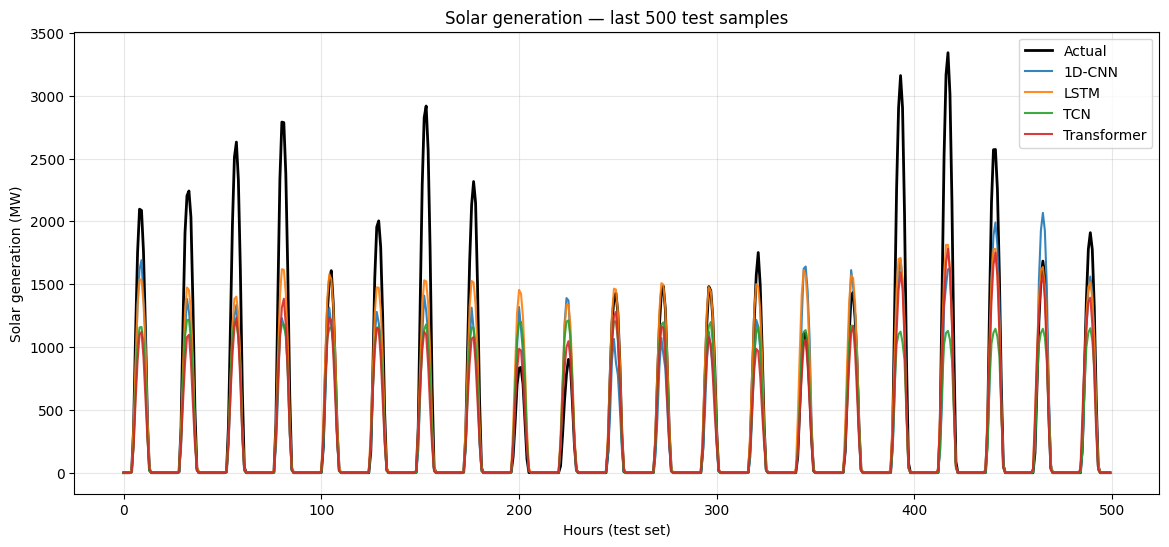

In [32]:



# Plot last N samples
N = 500
plt.figure(figsize=(14,6))
plt.plot(y_test_inv[-N:], label='Actual', color='black', linewidth=2)
plt.plot(y_pred_cnn_inv[-N:], label='1D-CNN', alpha=0.9)
plt.plot(y_pred_lstm_inv[-N:], label='LSTM', alpha=0.9)
plt.plot(y_pred_tcn_inv[-N:], label='TCN', alpha=0.9)
plt.plot(y_pred_tr_inv[-N:], label='Transformer', alpha=0.9)
plt.title(f"Solar generation — last {N} test samples")
plt.xlabel("Hours (test set)")
plt.ylabel("Solar generation (MW)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


# saving models 

In [37]:
import os

# Create directory if it doesn't exist
os.makedirs('improved_models', exist_ok=True)

# Save 1D-CNN model
cnn.save('improved_models/1D_CNN_model.keras')

# Save LSTM model
lstm.save('improved_models/LSTM_model.keras')

# Save TCN model (SavedModel folder)
tcn_model.save('improved_models/TCN_model.keras')  # No extension → SavedModel format

# Save Transformer model
transformer.save('improved_models/Transformer_model.keras')

print("✅ All models saved in 'improved_models' directory")


✅ All models saved in 'improved_models' directory


In [38]:
import joblib

joblib.dump(scaler_X, 'improved_models/scaler_X.save')
joblib.dump(scaler_y, 'improved_models/scaler_y.save')

print("✅ Scalers saved for future inference")

✅ Scalers saved for future inference


# loading saved models 

In [2]:
from tcn import TCN
from tensorflow.keras.models import load_model


In [3]:
cnn_loaded = load_model("improved_models/1D_CNN_model.keras")

lstm_loaded = load_model("improved_models/LSTM_model.keras")

tcn_loaded = load_model(
    "improved_models/TCN_model.keras",
    custom_objects={"TCN": TCN}
)

transformer_loaded = load_model("improved_models/Transformer_model.keras")


# Block A: Load models + scalers (handles TCN custom objects)


In [ ]:
# Block A: Load models + scalers (handles TCN custom objects)
import os
import joblib
import numpy as np
import tensorflow as tf

In [ ]:
# paths
MODEL_DIR = 'improved_models'
cnn_path = os.path.join(MODEL_DIR, '1D_CNN_model.keras')
lstm_path = os.path.join(MODEL_DIR, 'LSTM_model.keras')
tcn_path = os.path.join(MODEL_DIR, 'TCN_model.keras')            # SavedModel folder (recommended)
transformer_path = os.path.join(MODEL_DIR, 'Transformer_model.keras')

scaler_X_path = os.path.join(MODEL_DIR, 'scaler_X.save')
scaler_y_path = os.path.join(MODEL_DIR, 'scaler_y.save')


In [ ]:

# load scalers
scaler_X = joblib.load(scaler_X_path)   # if you saved them earlier
scaler_y = joblib.load(scaler_y_path)

In [ ]:

# Load Keras models. TCN uses custom layers from the `tcn` package, so add them to custom_objects.
# If you installed keras-tcn, import TCN and ResidualBlock for custom_objects mapping
try:
    from tcn import TCN
    import tcn as tcn_module
    custom_objs = {'TCN': TCN, 'ResidualBlock': getattr(tcn_module.tcn, 'ResidualBlock', None)}
except Exception:
    # if keras-tcn not available, load without custom objs (may error on TCN)
    custom_objs = {}

In [ ]:


print("Loading CNN...")
cnn = tf.keras.models.load_model(cnn_path, compile=False)

print("Loading LSTM...")
lstm = tf.keras.models.load_model(lstm_path, compile=False)

print("Loading TCN (may require keras-tcn to be installed)...")
# If TCN saved as SavedModel folder, load_model should read it as folder. Provide custom_objects mapping.


In [ ]:
tcn = None
try:
    tcn = tf.keras.models.load_model(tcn_path, custom_objects=custom_objs, compile=False)
    print("TCN loaded.")
except Exception as e:
    print("Warning: failed to load TCN via load_model with custom_objects. Error:")
    print(e)
    print("If this fails, ensure keras-tcn is installed (pip install keras-tcn) and restart runtime.")
    # fallback: try load with no custom objects
    try:
        tcn = tf.keras.models.load_model(tcn_path, compile=False)
        print("TCN loaded without explicit custom_objects.")
    except Exception as e2:
        print("Second attempt failed. TCN will be unavailable until custom objects are registered.")
        tcn = None


In [2]:

print("Loading Transformer...")
transformer = tf.keras.models.load_model(transformer_path, compile=False)

print("All available models loaded. Available objects:", 
      {k:v is not None for k,v in [('cnn',cnn),('lstm',lstm),('tcn',tcn),('transformer',transformer)]})


Loading CNN...
Loading LSTM...
Loading TCN (may require keras-tcn to be installed)...

TCN loaded.
Loading Transformer...
All available models loaded. Available objects: {'cnn': True, 'lstm': True, 'tcn': True, 'transformer': True}


# Block B: Predict (students) on VAL and TEST and inverse-transform back to MW

In [ ]:
# Block B: Predict (students) on VAL and TEST and inverse-transform back to MW
import numpy as np

# NOTE: you must have X_val, X_test, y_val, y_test in memory from your sequence-splitting step.
# If not, recreate them from your preprocessing / sequence code.

# Helper: inverse-transform a predicted array (student outputs are scaled on log1p then MinMax)
def inv_scale_preds(pred_scaled):
    # pred_scaled: shape (n,1) or (n,)
    pred_scaled = np.array(pred_scaled).reshape(-1,1)
    pred_log = scaler_y.inverse_transform(pred_scaled)   # this gives log1p(predicted_MW)
    pred_mw = np.expm1(pred_log)                         # back to MW
    pred_mw = np.clip(pred_mw, 0, None)
    return pred_mw.flatten()


In [ ]:

# Make predictions (on validation & test sets)
print("Predicting on VAL set...")
cnn_val_pred = cnn.predict(X_val)
lstm_val_pred = lstm.predict(X_val)
tcn_val_pred = tcn.predict(X_val) if tcn is not None else np.zeros_like(cnn_val_pred)

print("Predicting on TEST set...")
cnn_test_pred = cnn.predict(X_test)
lstm_test_pred = lstm.predict(X_test)
tcn_test_pred = tcn.predict(X_test) if tcn is not None else np.zeros_like(cnn_test_pred)


In [ ]:

# Inverse transform to MW
cnn_val_mw = inv_scale_preds(cnn_val_pred)
lstm_val_mw = inv_scale_preds(lstm_val_pred)
tcn_val_mw = inv_scale_preds(tcn_val_pred)

cnn_test_mw = inv_scale_preds(cnn_test_pred)
lstm_test_mw = inv_scale_preds(lstm_test_pred)
tcn_test_mw = inv_scale_preds(tcn_test_pred)

In [6]:


# Also get actual y in MW for val and test (needed as teacher target)
y_val_mw = np.expm1(scaler_y.inverse_transform(y_val.reshape(-1,1))).flatten()
y_test_mw = np.expm1(scaler_y.inverse_transform(y_test.reshape(-1,1))).flatten()

print("Shapes (val preds):", cnn_val_mw.shape, lstm_val_mw.shape, tcn_val_mw.shape)
print("Shapes (test preds):", cnn_test_mw.shape, lstm_test_mw.shape, tcn_test_mw.shape)
print("Actual val/test shapes:", y_val_mw.shape, y_test_mw.shape)


Predicting on VAL set...
164/164 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
164/164 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step
164/164 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step
Predicting on TEST set...
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
164/164 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step
164/164 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step
Shapes (val preds): (5233,) (5233,) (5233,)
Shapes (test preds): (5233,) (5233,) (5233,)
Actual val/test shapes: (5233,) (5233,)


# Block C: Prepare teacher inputs (stacked predictions). Use VAL as teacher-train, TEST as teacher-eval

In [ ]:
# Block C: Prepare teacher inputs (stacked predictions). Use VAL as teacher-train, TEST as teacher-eval
import numpy as np

# Stack student predictions as columns (students: CNN, LSTM, TCN)
X_teacher_train = np.vstack([cnn_val_mw, lstm_val_mw, tcn_val_mw]).T   # shape (n_val, 3)
X_teacher_test  = np.vstack([cnn_test_mw, lstm_test_mw, tcn_test_mw]).T

y_teacher_train = y_val_mw.reshape(-1,1)
y_teacher_test  = y_test_mw.reshape(-1,1)

print("Teacher train shape:", X_teacher_train.shape, y_teacher_train.shape)
print("Teacher test shape:", X_teacher_test.shape, y_teacher_test.shape)

In [7]:


# Optional: add derived features (ensemble mean, std)
import pandas as pd
def add_ensemble_features(X_stack):
    df_tmp = pd.DataFrame(X_stack, columns=['cnn','lstm','tcn'])
    df_tmp['mean'] = df_tmp.mean(axis=1)
    df_tmp['std'] = df_tmp.std(axis=1)
    return df_tmp.values

# Example: include mean/std as extra columns (uncomment if you want)
# X_teacher_train = add_ensemble_features(X_teacher_train)
# X_teacher_test  = add_ensemble_features(X_teacher_test)


Teacher train shape: (5233, 3) (5233, 1)
Teacher test shape: (5233, 3) (5233, 1)


# Block D: NN Teacher

In [ ]:
# Block D: NN Teacher
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np


In [ ]:

input_dim = X_teacher_train.shape[1]

teacher_nn = Sequential([
    Dense(64, activation='relu', input_shape=(input_dim,)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.1),
    Dense(1)
])

In [ ]:


teacher_nn.compile(optimizer='adam', loss='mse', metrics=['mae'])
teacher_nn.summary()

es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, min_lr=1e-7, verbose=1)


In [9]:

# Train on VAL predictions (teacher uses student outputs on VAL as training)
history_teacher_nn = teacher_nn.fit(X_teacher_train, y_teacher_train,
                                   validation_data=(X_teacher_test, y_teacher_test),
                                   epochs=200, batch_size=32, callbacks=[ rlr], verbose=1)

# Predict and invert (teacher outputs are already in MW since students were inverted)
y_pred_nn_test = teacher_nn.predict(X_teacher_test).flatten()
y_true_test = y_teacher_test.flatten()

# Evaluate (mask small actuals for MAPE)
mask = y_true_test > 10
mae_nn = mean_absolute_error(y_true_test[mask], y_pred_nn_test[mask])
rmse_nn = np.sqrt(mean_squared_error(y_true_test[mask], y_pred_nn_test[mask]))
mape_nn = np.mean(np.abs((y_true_test[mask] - y_pred_nn_test[mask]) / y_true_test[mask])) * 100

print(f"NN Teacher | MAE: {mae_nn:.2f} MW | RMSE: {rmse_nn:.2f} MW | Masked MAPE: {mape_nn:.2f}%")


d:\deepleanring project\venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,369 (9.25 KB)

 Trainable params: 2,369 (9.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 290766.7500 - mae: 235.4567 - val_loss: 141697.8438 - val_mae: 193.8067 - learning_rate: 0.0010
Epoch 2/200
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 128999.8828 - mae: 170.3593 - val_loss: 110457.3125 - val_mae: 171.9691 - learning_rate: 0.0010
Epoch 3/200
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 121284.5000 - mae: 164.1711 - val_loss: 96445.8672 - val_mae: 162.1078 - learning_rate: 0.0010
Epoch 4/200
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 113225.7812 - mae: 158.1834 - val_loss: 128516.9688 - val_mae: 183.9968 - learning_rate: 0.0010
Epoch 5/200
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 113088.4531 - mae: 159.0264 - val_loss: 134032.9688 - val_mae: 187.3259 - learning_rate: 0.0010
Epoch 6/200
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 107094.7969 - mae: 156.8558 - val_loss: 97154.3438 - val_mae: 161.8287 - learning_rate: 0.0010
Epoch 7/200
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss:

In [11]:
%pip install xgboost

   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.5/72.0 MB 381.6 kB/s eta 0:03:08
   ---------------------------------------- 0.8/72.0 MB 559.5 kB/s eta 0:02:08
   ---------------------------------------- 0.8/72.0 MB 559.5 kB/s eta 0:02:08
    --------------------------------------- 1.0/72.0 MB 662.5 kB/s eta 0:01:48
    --------------------------------------- 1.3/72.0 M


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


# Block E: XGBoost Teacher

In [ ]:
# Block E: XGBoost Teacher
# Install if needed: pip install xgboost
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np


In [ ]:
# Flatten targets for XGBoost
y_train_xgb = y_teacher_train.flatten()
y_test_xgb  = y_teacher_test.flatten()

# Create and train XGBoost regressor
teacher_xgb = xgb.XGBRegressor(n_estimators=500, max_depth=4, learning_rate=0.05, verbosity=1, n_jobs=4)


In [13]:

teacher_xgb.fit(X_teacher_train, y_train_xgb, eval_set=[(X_teacher_test, y_test_xgb)], verbose=20)

# Predict
y_pred_xgb_test = teacher_xgb.predict(X_teacher_test)

# Evaluate with same mask
mask = y_test_xgb > 10
mae_xgb = mean_absolute_error(y_test_xgb[mask], y_pred_xgb_test[mask])
rmse_xgb = np.sqrt(mean_squared_error(y_test_xgb[mask], y_pred_xgb_test[mask]))
mape_xgb = np.mean(np.abs((y_test_xgb[mask] - y_pred_xgb_test[mask]) / y_test_xgb[mask])) * 100

print(f"XGBoost Teacher | MAE: {mae_xgb:.2f} MW | RMSE: {rmse_xgb:.2f} MW | Masked MAPE: {mape_xgb:.2f}%")


[0]	validation_0-rmse:1361.20159
[20]	validation_0-rmse:591.88532
[40]	validation_0-rmse:387.64084
[60]	validation_0-rmse:345.99493
[80]	validation_0-rmse:339.22673
[100]	validation_0-rmse:338.60639
[120]	validation_0-rmse:340.41274
[140]	validation_0-rmse:342.60603
[160]	validation_0-rmse:345.29644
[180]	validation_0-rmse:347.22706
[200]	validation_0-rmse:349.13970
[220]	validation_0-rmse:350.83528
[240]	validation_0-rmse:351.70726
[260]	validation_0-rmse:353.70574
[280]	validation_0-rmse:355.77856
[300]	validation_0-rmse:357.20892
[320]	validation_0-rmse:357.98447
[340]	validation_0-rmse:359.05870
[360]	validation_0-rmse:359.89357
[380]	validation_0-rmse:361.01959
[400]	validation_0-rmse:362.27352
[420]	validation_0-rmse:363.17072
[440]	validation_0-rmse:363.71605
[460]	validation_0-rmse:364.55400
[480]	validation_0-rmse:365.19189
[499]	validation_0-rmse:365.84084
XGBoost Teacher | MAE: 348.53 MW | RMSE: 503.20 MW | Masked MAPE: 24.21%


# Block F: Compare & Plot


In [ ]:
# Block F: Compare & Plot
import matplotlib.pyplot as plt
from tabulate import tabulate
import numpy as np

In [ ]:


# Prepare teacher predictions
y_pred_nn = y_pred_nn_test
y_pred_xgb = y_pred_xgb_test
y_true = y_true_test


In [ ]:

metrics = [
    ["NN Teacher", mae_nn, rmse_nn, mape_nn],
    ["XGBoost Teacher", mae_xgb, rmse_xgb, mape_xgb]
]
print(tabulate(metrics, headers=["Model","MAE (MW)","RMSE (MW)","Masked MAPE (%)"], tablefmt="github", floatfmt=".2f"))


| Model           |   MAE (MW) |   RMSE (MW) |   Masked MAPE (%) |
|-----------------|------------|-------------|-------------------|
| NN Teacher      |     346.70 |      493.75 |             22.34 |
| XGBoost Teacher |     348.53 |      503.20 |             24.21 |


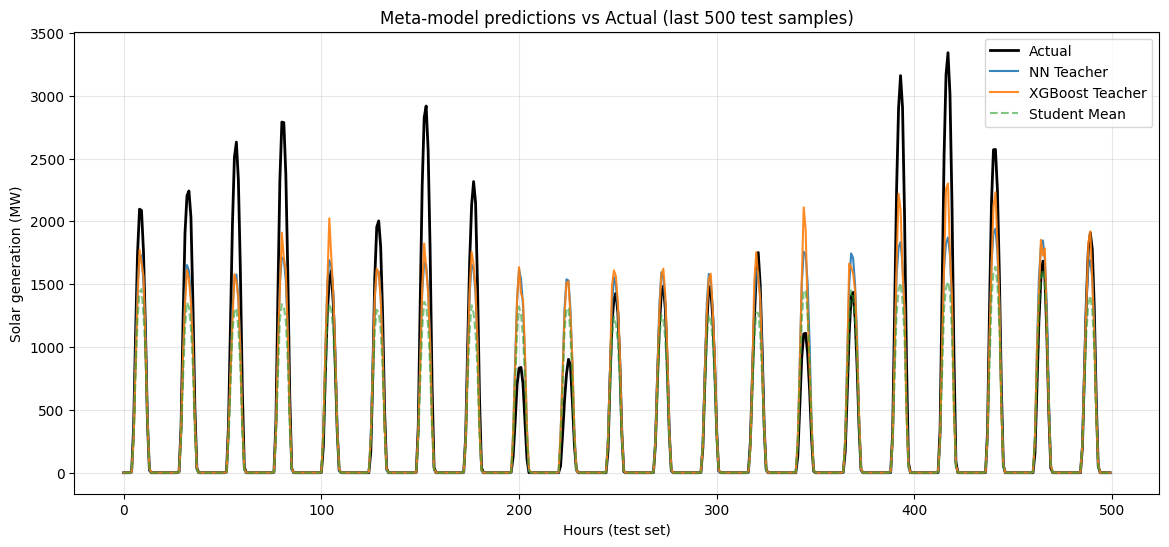

In [ ]:

# Plot last N points
N = 500
plt.figure(figsize=(14,6))
plt.plot(y_true[-N:], label='Actual', color='black', linewidth=2)
plt.plot(y_pred_nn[-N:], label='NN Teacher', alpha=0.9)
plt.plot(y_pred_xgb[-N:], label='XGBoost Teacher', alpha=0.9)
# also show student ensemble mean for reference
student_mean_test = np.mean(np.vstack([cnn_test_mw, lstm_test_mw, tcn_test_mw]).T, axis=1)
plt.plot(student_mean_test[-N:], label='Student Mean', alpha=0.6, linestyle='--')
plt.title('Meta-model predictions vs Actual (last %d test samples)'%N)
plt.xlabel('Hours (test set)')
plt.ylabel('Solar generation (MW)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


Loading scalers...
Scalers loaded.
Scaler has no feature_names_in_. Expected number of features: 17
Loading CSVs and merging...
Preparing feature matrix to match scaler expectation...
Number of features used: 17
Feature columns used (first 20): ['FR_load_actual_entsoe_power_statistics', 'FR_load_actual_tso', 'FR_load_forecast_tso', 'FR_wind_onshore_generation_actual', 'FR_windspeed_10m', 'FR_temperature', 'FR_radiation_direct_horizontal', 'FR_radiation_diffuse_horizontal', 'hour', 'dayofweek', 'month', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'month_sin', 'month_cos']
Creating sequences with lookback = 168
Train/Val/Test sizes: 24419 5233 5233
Loading student models (CNN, LSTM, TCN)...
CNN loaded.
LSTM loaded.
TCN loaded.
Generating student predictions (and converting to MW)...

Student baselines on TEST set (masked):
 CNN  | MAE: 491.84 | RMSE: 676.95 | Masked MAPE: 27.81%
 LSTM | MAE: 472.43 | RMSE: 665.85 | Masked MAPE: 35.75%
 TCN  | MAE: 613.33 | RMSE: 836.50 | Masked MAPE: 3

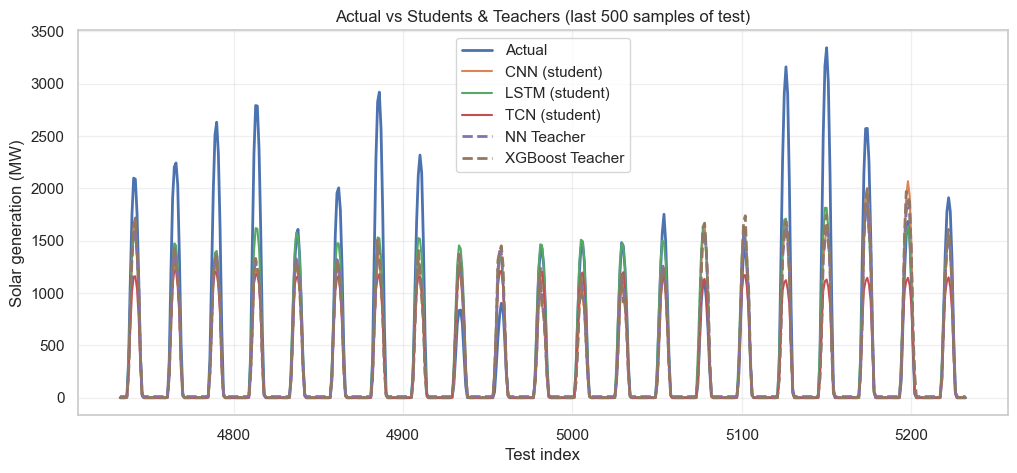

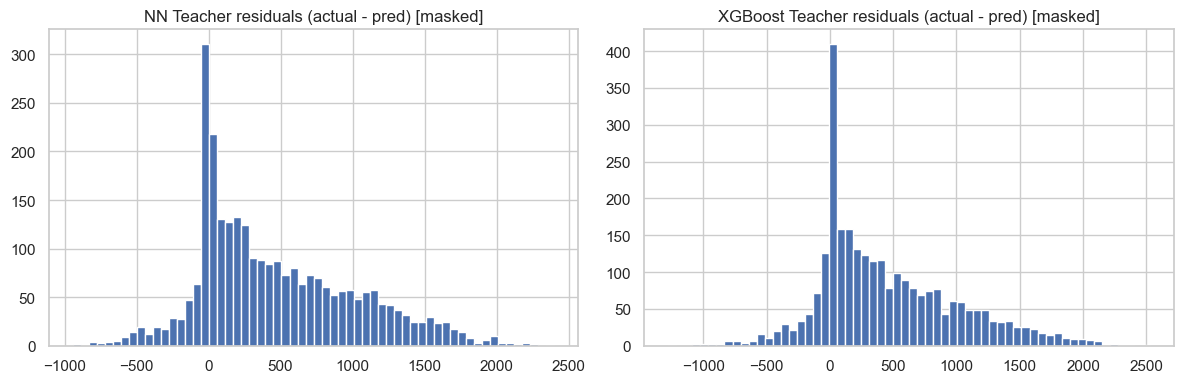

Saved teacher metadata and predictions in improved_models

All done. Use predict_pipeline(X_seq_scaled) with X_seq_scaled prepared (scaled with scaler_X).
Saved teachers: improved_models\Teacher_NN.keras improved_models\Teacher_XGBoost.joblib


In [23]:
# final_meta_pipeline_ready.py
# Single-file end-to-end meta-model pipeline (students -> teacher stacking).
# Students: CNN, LSTM, TCN (all used at inference)
# Teachers: NN and improved XGBoost (both trained); XGBoost selected for final deployment.
# No early stopping used (per user request).

import os, joblib, math, warnings
import numpy as np, pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
import matplotlib.pyplot as plt

# -----------------------
# USER CONFIG
# -----------------------
MODEL_DIR = 'improved_models'
os.makedirs(MODEL_DIR, exist_ok=True)

# Student model filenames (adjust if you used different names)
CNN_FILE = os.path.join(MODEL_DIR, '1D_CNN_model.keras')
LSTM_FILE = os.path.join(MODEL_DIR, 'LSTM_model.keras')
TCN_FILE = os.path.join(MODEL_DIR, 'TCN_model.keras')   # you fixed filename earlier
SCALER_X_FILE = os.path.join(MODEL_DIR, 'scaler_X.save')
SCALER_Y_FILE = os.path.join(MODEL_DIR, 'scaler_y.save')

TEACHER_NN_FILE = os.path.join(MODEL_DIR, 'Teacher_NN.keras')
TEACHER_XGB_FILE = os.path.join(MODEL_DIR, 'Teacher_XGBoost.joblib')
TEACHER_SCALER_FILE = os.path.join(MODEL_DIR, 'teacher_feature_scaler.joblib')
TEACHER_META_FILE = os.path.join(MODEL_DIR, 'teacher_meta_info.joblib')

# CSVs (update if paths differ)
TS_CSV = "Data_in_France/time_series.csv"
WEA_CSV = ".csv"

LOOKBACK = 168
MASK_THRESHOLD = 10.0  # used for masked MAPE

# -----------------------
# UTIL FUNCTIONS
# -----------------------
def masked_metrics(y_true, y_pred, threshold=MASK_THRESHOLD):
    mask = (y_true > threshold)
    if mask.sum() == 0:
        return (np.nan, np.nan, np.nan)
    mae = mean_absolute_error(y_true[mask], y_pred[mask])
    rmse = math.sqrt(mean_squared_error(y_true[mask], y_pred[mask]))
    mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    return mae, rmse, mape

def create_sequences(X, y, lookback=LOOKBACK):
    Xs, ys = [], []
    for i in range(lookback, len(X)):
        Xs.append(X[i-lookback:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

def inv_scale_preds(pred_scaled, scaler_y):
    p = np.array(pred_scaled).reshape(-1,1)
    log1p = scaler_y.inverse_transform(p)   # returns log1p(y)
    raw = np.expm1(log1p).flatten()
    raw = np.clip(raw, 0, None)
    return raw

# -----------------------
# 1) Load scalers & get expected feature names/shape
# -----------------------
print("Loading scalers...")
if not os.path.exists(SCALER_X_FILE) or not os.path.exists(SCALER_Y_FILE):
    raise FileNotFoundError(f"Scaler files not found in {MODEL_DIR}. Place scaler_X.save and scaler_y.save there.")
scaler_X = joblib.load(SCALER_X_FILE)
scaler_y = joblib.load(SCALER_Y_FILE)
print("Scalers loaded.")

# try to get original feature names from scaler (sklearn stores feature_names_in_ sometimes)
expected_n_features = getattr(scaler_X, 'n_features_in_', None)
feature_names_in = getattr(scaler_X, 'feature_names_in_', None)
if feature_names_in is not None:
    feature_names_in = list(feature_names_in)
    print("Scaler has feature_names_in_. Using exact feature list length:", len(feature_names_in))
else:
    print("Scaler has no feature_names_in_. Expected number of features:", expected_n_features)

# -----------------------
# 2) Load and preprocess raw CSVs, align features to scaler expectation
# -----------------------
print("Loading CSVs and merging...")
if not (os.path.exists(TS_CSV) and os.path.exists(WEA_CSV)):
    raise FileNotFoundError("CSV files not found at expected paths. Place them or update TS_CSV and WEA_CSV paths in the script.")

df1 = pd.read_csv(TS_CSV)
df2 = pd.read_csv(WEA_CSV)
df = pd.merge(df1, df2, on='utc_timestamp')
df['utc_timestamp'] = pd.to_datetime(df['utc_timestamp'])
df.set_index('utc_timestamp', inplace=True)

# Drop columns that were previously dropped in pipeline (safe)
for c in ['FR_load_forecast_entsoe_transparency','FR_load_actual_entsoe_transparency','cet_cest_timestamp']:
    if c in df.columns:
        df.drop(c, axis=1, inplace=True)

# Add cyclical temporal features used earlier if not present
if 'hour' not in df.columns:
    df['hour'] = df.index.hour
if 'dayofweek' not in df.columns:
    df['dayofweek'] = df.index.dayofweek
if 'month' not in df.columns:
    df['month'] = df.index.month
df['hour_sin'] = np.sin(2*np.pi*df['hour']/24)
df['hour_cos'] = np.cos(2*np.pi*df['hour']/24)
df['dow_sin'] = np.sin(2*np.pi*df['dayofweek']/7)
df['dow_cos'] = np.cos(2*np.pi*df['dayofweek']/7)
df['month_sin'] = np.sin(2*np.pi*(df['month']-1)/12)
df['month_cos'] = np.cos(2*np.pi*(df['month']-1)/12)

df.dropna(inplace=True)   # keep same as training

# Target column (your dataset): use exact name present
if 'FR_solar_generation_actual' in df.columns:
    TARGET_COL = 'FR_solar_generation_actual'
else:
    # fallback: last numeric column that looks like solar
    cand = [c for c in df.columns if 'solar' in c.lower()]
    if cand:
        TARGET_COL = cand[0]
    else:
        raise ValueError("Target column FR_solar_generation_actual not found in merged CSVs.")

# Build X_raw using scaler metadata if available
print("Preparing feature matrix to match scaler expectation...")
if feature_names_in is not None:
    missing = [c for c in feature_names_in if c not in df.columns]
    if missing:
        raise ValueError(f"Scaler expected feature names but these are missing in CSV: {missing}. Fix CSV or scaler mapping.")
    X_raw = df[feature_names_in].values
    feature_cols_used = feature_names_in
else:
    # Heuristic matching: choose columns present in df that likely correspond to training features
    candidate_priority = [
        # explicit weather and domain columns likely present
        'FR_windspeed_10m','FR_temperature','FR_radiation_direct_horizontal','FR_radiation_diffuse_horizontal',
        'FR_wind_onshore_generation_actual','FR_solar_generation_actual',
        # common names
        'windspeed_10m','temperature','radiation_direct_horizontal','radiation_diffuse_horizontal',
        'radiation_direct','radiation_diffuse','radiation','shortwave_radiation','direct_solar_radiation','diffuse_radiation',
        # temporal sines/coses
        'hour_sin','hour_cos','dow_sin','dow_cos','month_sin','month_cos',
        # loads
        'FR_load_actual_tso','FR_load_actual_entsoe_power_statistics','FR_load_forecast_tso'
    ]
    available = [c for c in candidate_priority if c in df.columns]
    # If scaler reports expected_n_features, try to match that many; otherwise pick all available
    if expected_n_features is not None:
        if len(available) >= expected_n_features:
            feature_cols_used = available[:expected_n_features]
        else:
            # not enough matched columns: fall back to selecting all numeric columns except target, then pad with zeros
            numeric_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c != TARGET_COL]
            # ensure hour_sin etc included
            for c in ['hour_sin','hour_cos','dow_sin','dow_cos','month_sin','month_cos']:
                if c in df.columns and c not in numeric_cols:
                    numeric_cols.append(c)
            if len(numeric_cols) >= expected_n_features:
                feature_cols_used = numeric_cols[:expected_n_features]
            else:
                # pad with zeros by repeating last numeric column name (we'll create zero columns)
                feature_cols_used = numeric_cols.copy()
                # create additional synthetic columns
                needed = expected_n_features - len(feature_cols_used)
                for i in range(needed):
                    name = f'_pad_feature_{i}'
                    df[name] = 0.0
                    feature_cols_used.append(name)
                warnings.warn("Not enough matching feature columns; padding with zero columns to match scaler expected input.")
    else:
        # expected size unknown: use available candidate list or all numeric
        if available:
            feature_cols_used = available
        else:
            feature_cols_used = [c for c in df.select_dtypes(include=[np.number]).columns if c != TARGET_COL]
    X_raw = df[feature_cols_used].values

print("Number of features used:", len(feature_cols_used))
print("Feature columns used (first 20):", feature_cols_used[:20])

# Scale X and y using loaded scalers (scaler_X expects same feature order)
try:
    X_scaled = scaler_X.transform(X_raw)
except Exception as e:
    # fallback: if scaler expects different shape, try to adapt by truncating or padding columns
    expected = getattr(scaler_X, 'n_features_in_', None)
    if expected is None:
        raise e
    got = X_raw.shape[1]
    if got > expected:
        print(f"Warning: got {got} columns but scaler expects {expected}. Truncating right-most columns.")
        X_scaled = scaler_X.transform(X_raw[:, :expected])
        feature_cols_used = feature_cols_used[:expected]
    else:
        # pad zeros
        print(f"Warning: got {got} columns but scaler expects {expected}. Padding with zeros.")
        pad = np.zeros((X_raw.shape[0], expected-got))
        X_scaled = scaler_X.transform(np.hstack([X_raw, pad]))
        # add pad names
        for i in range(expected-got):
            feature_cols_used.append(f'_pad_feature_{i}')

y_raw = np.clip(df[TARGET_COL].values, 0, None)
y_log1p = np.log1p(y_raw).reshape(-1,1)
y_scaled = scaler_y.transform(y_log1p)

# -----------------------
# 3) Create sequences (LOOKBACK) and split
# -----------------------
print("Creating sequences with lookback =", LOOKBACK)
X_seq, y_seq = create_sequences(X_scaled, y_scaled, LOOKBACK)
n = len(X_seq)
split1 = int(0.7 * n)
split2 = int(0.85 * n)
X_train, y_train = X_seq[:split1], y_seq[:split1]
X_val, y_val = X_seq[split1:split2], y_seq[split1:split2]
X_test, y_test = X_seq[split2:], y_seq[split2:]

# raw MW targets for evaluation
y_train_mw = inv_scale_preds(y_train, scaler_y)
y_val_mw = inv_scale_preds(y_val, scaler_y)
y_test_mw = inv_scale_preds(y_test, scaler_y)

print("Train/Val/Test sizes:", X_train.shape[0], X_val.shape[0], X_test.shape[0])

# -----------------------
# 4) Load student models
# -----------------------
print("Loading student models (CNN, LSTM, TCN)...")
cnn = load_model(CNN_FILE, compile=False)
print("CNN loaded.")
lstm = load_model(LSTM_FILE, compile=False)
print("LSTM loaded.")
tcn = None
try:
    tcn = load_model(TCN_FILE, compile=False)
    print("TCN loaded.")
except Exception as e:
    print("Warning: TCN could not be loaded (custom layer or format). Continuing without TCN. Error:", e)
    tcn = None

# -----------------------
# 5) Student predictions -> convert to MW
# -----------------------
print("Generating student predictions (and converting to MW)...")
def pred_to_mw(model, X):
    p = model.predict(X, verbose=0)
    return inv_scale_preds(p, scaler_y)

cnn_train = pred_to_mw(cnn, X_train); cnn_val = pred_to_mw(cnn, X_val); cnn_test = pred_to_mw(cnn, X_test)
lstm_train = pred_to_mw(lstm, X_train); lstm_val = pred_to_mw(lstm, X_val); lstm_test = pred_to_mw(lstm, X_test)
if tcn is not None:
    tcn_train = pred_to_mw(tcn, X_train); tcn_val = pred_to_mw(tcn, X_val); tcn_test = pred_to_mw(tcn, X_test)
else:
    # zeros so teacher still works (but teacher will learn to ignore)
    tcn_train = np.zeros_like(cnn_train); tcn_val = np.zeros_like(cnn_val); tcn_test = np.zeros_like(cnn_test)

# print student baselines
print("\nStudent baselines on TEST set (masked):")
for name, preds in [('CNN', cnn_test), ('LSTM', lstm_test), ('TCN', tcn_test)]:
    mae, rmse, mape = masked_metrics(y_test_mw, preds, MASK_THRESHOLD)
    print(f" {name:<4} | MAE: {mae:.2f} | RMSE: {rmse:.2f} | Masked MAPE: {mape:.2f}%")

# -----------------------
# 6) Build teacher dataset: stack students + meta features
# -----------------------
def stack_features(a,b,c):
    base = np.vstack([a,b,c]).T
    mean = base.mean(axis=1).reshape(-1,1)
    std = base.std(axis=1).reshape(-1,1)
    mn = base.min(axis=1).reshape(-1,1)
    mx = base.max(axis=1).reshape(-1,1)
    return np.hstack([base, mean, std, mn, mx])

X_teacher_train = stack_features(cnn_train, lstm_train, tcn_train)
X_teacher_val   = stack_features(cnn_val, lstm_val, tcn_val)
X_teacher_test  = stack_features(cnn_test, lstm_test, tcn_test)

y_teacher_train = y_train_mw
y_teacher_val   = y_val_mw
y_teacher_test  = y_test_mw

# Standardize teacher features for NN teacher
teacher_scaler = StandardScaler()
teacher_scaler.fit(np.vstack([X_teacher_train, X_teacher_val]))
X_teacher_train_s = teacher_scaler.transform(X_teacher_train)
X_teacher_val_s = teacher_scaler.transform(X_teacher_val)
X_teacher_test_s = teacher_scaler.transform(X_teacher_test)
joblib.dump(teacher_scaler, TEACHER_SCALER_FILE)

print("Teacher feature shape:", X_teacher_train.shape)

# -----------------------
# 7) Train NN teacher (no early stopping)
# -----------------------
print("\nTraining NN teacher (fixed epochs, no early stopping)...")
inp_dim = X_teacher_train_s.shape[1]
teacher_nn = Sequential([
    Dense(128, activation='relu', input_shape=(inp_dim,)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.1),
    Dense(1)
])
teacher_nn.compile(optimizer=Adam(1e-3), loss='mse', metrics=['mae'])
EPOCHS_NN = 100
BATCH_NN = 128
teacher_nn.fit(X_teacher_train_s, y_teacher_train, validation_data=(X_teacher_val_s, y_teacher_val),
               epochs=EPOCHS_NN, batch_size=BATCH_NN, verbose=1)
teacher_nn.save(TEACHER_NN_FILE)
print("NN teacher saved:", TEACHER_NN_FILE)

y_pred_nn_test = teacher_nn.predict(X_teacher_test_s).flatten()
mae_nn, rmse_nn, mape_nn = masked_metrics(y_teacher_test, y_pred_nn_test, MASK_THRESHOLD)
print("NN Teacher test (masked) -> MAE: %.2f | RMSE: %.2f | MAPE: %.2f%%" % (mae_nn, rmse_nn, mape_nn))

# -----------------------
# 8) Train improved XGBoost teacher (no early stopping), stronger hyperparams
# -----------------------
print("\nTraining improved XGBoost teacher (no early stopping)...")
xgb_params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.03,
    'max_depth': 6,
    'subsample': 0.85,
    'colsample_bytree': 0.85,
    'n_estimators': 2000,
    'reg_lambda': 2.0,
    'reg_alpha': 0.5,
    'random_state': 42,
    'n_jobs': 4,
    'verbosity': 1
}
xgb_model = xgb.XGBRegressor(**xgb_params)
# Train on TRAIN only to keep evaluation clean; no early stopping
xgb_model.fit(X_teacher_train, y_teacher_train)
joblib.dump(xgb_model, TEACHER_XGB_FILE)
print("XGBoost teacher saved:", TEACHER_XGB_FILE)

y_pred_xgb_test = xgb_model.predict(X_teacher_test)
mae_xgb, rmse_xgb, mape_xgb = masked_metrics(y_teacher_test, y_pred_xgb_test, MASK_THRESHOLD)
print("XGBoost Teacher test (masked) -> MAE: %.2f | RMSE: %.2f | MAPE: %.2f%%" % (mae_xgb, rmse_xgb, mape_xgb))

# -----------------------
# 9) Results table + plots
# -----------------------
results = pd.DataFrame([
    ['CNN (student)', *masked_metrics(y_test_mw, cnn_test, MASK_THRESHOLD)],
    ['LSTM (student)', *masked_metrics(y_test_mw, lstm_test, MASK_THRESHOLD)],
    ['TCN (student)', *masked_metrics(y_test_mw, tcn_test, MASK_THRESHOLD)],
    ['NN Teacher', mae_nn, rmse_nn, mape_nn],
    ['XGBoost Teacher', mae_xgb, rmse_xgb, mape_xgb]
], columns=['Model','MAE','RMSE','Masked_MAPE']).sort_values('RMSE')

print("\nFINAL METRICS (masked):")
print(results.to_string(index=False))

# Plot actual vs predictions (last N points)
N = 500
start = max(0, len(y_teacher_test)-N)
t_idx = np.arange(start, len(y_teacher_test))
plt.figure(figsize=(12,5))
plt.plot(t_idx, y_teacher_test[start:], label='Actual', linewidth=2)
plt.plot(t_idx, cnn_test[start:], label='CNN (student)')
plt.plot(t_idx, lstm_test[start:], label='LSTM (student)')
if tcn is not None:
    plt.plot(t_idx, tcn_test[start:], label='TCN (student)')
plt.plot(t_idx, y_pred_nn_test[start:], '--', label='NN Teacher', linewidth=2)
plt.plot(t_idx, y_pred_xgb_test[start:], '--', label='XGBoost Teacher', linewidth=2)
plt.legend()
plt.title("Actual vs Students & Teachers (last %d samples of test)" % N)
plt.xlabel("Test index")
plt.ylabel("Solar generation (MW)")
plt.grid(alpha=0.3)
plt.show()

# Residual histograms
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(y_teacher_test[y_teacher_test>MASK_THRESHOLD] - y_pred_nn_test[y_teacher_test>MASK_THRESHOLD], bins=60)
plt.title("NN Teacher residuals (actual - pred) [masked]")
plt.subplot(1,2,2)
plt.hist(y_teacher_test[y_teacher_test>MASK_THRESHOLD] - y_pred_xgb_test[y_teacher_test>MASK_THRESHOLD], bins=60)
plt.title("XGBoost Teacher residuals (actual - pred) [masked]")
plt.tight_layout()
plt.show()

# -----------------------
# 10) Save teacher metadata & preds
# -----------------------
teacher_meta = {
    'students': ['cnn','lstm','tcn' if tcn is not None else None],
    'feature_columns_used': feature_cols_used,
    'teacher_feature_names': ['cnn_pred','lstm_pred','tcn_pred','mean','std','min','max'],
    'mask_threshold': MASK_THRESHOLD,
    'LOOKBACK': LOOKBACK
}
joblib.dump(teacher_meta, TEACHER_META_FILE)
np.save(os.path.join(MODEL_DIR, 'y_pred_nn_test.npy'), y_pred_nn_test)
np.save(os.path.join(MODEL_DIR, 'y_pred_xgb_test.npy'), y_pred_xgb_test)
print("Saved teacher metadata and predictions in", MODEL_DIR)

# -----------------------
# 11) Deployment helper: predict_pipeline(X_seq_scaled)
# -----------------------
def predict_pipeline(X_seq_scaled):
    """
    X_seq_scaled: numpy array shape (n_samples, LOOKBACK, n_features) with same order used by scaler_X
    Returns: final predictions (XGBoost teacher) in MW (1D array)
    """
    if X_seq_scaled.ndim != 3:
        raise ValueError("X_seq_scaled must be shape (n_samples, LOOKBACK, n_features)")

    # load students & teacher
    cnn_local = load_model(CNN_FILE, compile=False)
    lstm_local = load_model(LSTM_FILE, compile=False)
    try:
        tcn_local = load_model(TCN_FILE, compile=False)
    except Exception:
        tcn_local = None
    teacher_scaler_local = joblib.load(TEACHER_SCALER_FILE)
    xgb_local = joblib.load(TEACHER_XGB_FILE)

    # students -> preds in MW
    def pred_mw_local(model, Xs):
        p = model.predict(Xs, verbose=0)
        return inv_scale_preds(p, scaler_y)

    p_c = pred_mw_local(cnn_local, X_seq_scaled)
    p_l = pred_mw_local(lstm_local, X_seq_scaled)
    if tcn_local is not None:
        p_t = pred_mw_local(tcn_local, X_seq_scaled)
    else:
        p_t = np.zeros_like(p_c)

    base = np.vstack([p_c, p_l, p_t]).T
    mean = base.mean(axis=1).reshape(-1,1)
    std = base.std(axis=1).reshape(-1,1)
    mn = base.min(axis=1).reshape(-1,1)
    mx = base.max(axis=1).reshape(-1,1)
    X_meta = np.hstack([base, mean, std, mn, mx])

    # XGBoost expects raw teacher features as used in training (we trained XGBoost on raw stacked features)
    final = xgb_local.predict(X_meta)
    final = np.clip(final, 0, None)
    return final

print("\nAll done. Use predict_pipeline(X_seq_scaled) with X_seq_scaled prepared (scaled with scaler_X).")
print("Saved teachers:", TEACHER_NN_FILE, TEACHER_XGB_FILE)


Loading scalers...
Scalers loaded.
Loading CSVs and preprocessing...
Using feature columns (count): 17
Creating sequences with LOOKBACK = 168
Train/Val/Test sizes: 24419 5233 5233
Loading student models...
CNN loaded.
LSTM loaded.
TCN loaded.
Getting student predictions (train/val/test) and converting to MW...

Student baseline metrics on TEST set (masked):
CNN   | MAE: 491.84 | RMSE: 676.95 | Masked MAPE: 27.81%
LSTM  | MAE: 472.43 | RMSE: 665.85 | Masked MAPE: 35.75%
TCN   | MAE: 613.33 | RMSE: 836.50 | Masked MAPE: 32.03%
Building teacher features (raw features + student preds + stats)...
Teacher shapes: (24419, 24) (5233, 24) (5233, 24)
Training NN teacher (no early stopping)...
Epoch 1/80
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1454032.5000 - mae: 687.9892 - val_loss: 1710216.6250 - val_mae: 713.1313
Epoch 2/80
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1428914.6250 - mae: 682.6558 - val_loss: 1673848.6250 - val_mae: 706.5010
Epoch 3/80
191/191 ━━━━━━━━━━━━━━━━━━━━ 

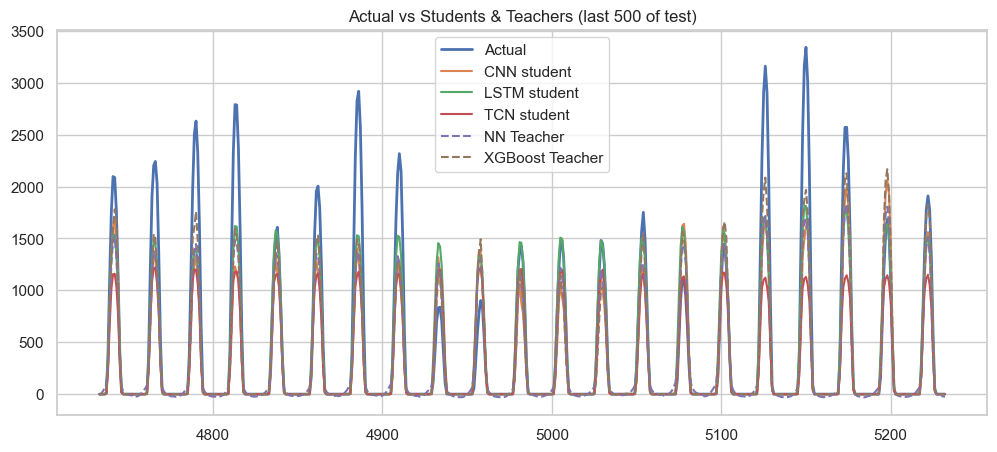

Saved teacher metadata: improved_models\teacher_meta_info.joblib

Pipeline ready. Use predict_pipeline(raw_windows) for inference. final XGBoost saved at: improved_models\Teacher_XGBoost.joblib


In [26]:
# final_master_pipeline.py
# Single runnable file: preprocessing -> students -> teacher stacking -> train teachers -> save XGBoost for deployment

import os, joblib, math, warnings
import numpy as np, pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
import matplotlib.pyplot as plt

# ----------------------
# CONFIG - update if needed
# ----------------------
MODEL_DIR = 'improved_models'
os.makedirs(MODEL_DIR, exist_ok=True)
SCALER_X_FILE = os.path.join(MODEL_DIR, 'scaler_X.save')
SCALER_Y_FILE = os.path.join(MODEL_DIR, 'scaler_y.save')

CNN_FILE = os.path.join(MODEL_DIR, '1D_CNN_model.keras')
LSTM_FILE = os.path.join(MODEL_DIR, 'LSTM_model.keras')
TCN_FILE = os.path.join(MODEL_DIR, 'TCN_model.keras')  # if not available, script will continue without TCN

# CSV paths (change if your files are elsewhere)
TS_CSV = "Data_in_France/time_series.csv"
WEA_CSV = "Data_in_France/weather_data.csv"

TARGET_COL = 'FR_solar_generation_actual'
LOOKBACK = 168
MASK_THRESHOLD = 10.0  # for masked MAPE

# Teacher save paths
TEACHER_NN_FILE = os.path.join(MODEL_DIR, 'Teacher_NN.keras')
TEACHER_XGB_FILE = os.path.join(MODEL_DIR, 'Teacher_XGBoost.joblib')
TEACHER_META_FILE = os.path.join(MODEL_DIR, 'teacher_meta_info.joblib')

# ----------------------
# Helpers
# ----------------------
def masked_metrics(y_true, y_pred, threshold=MASK_THRESHOLD):
    mask = (y_true > threshold)
    if mask.sum() == 0:
        return np.nan, np.nan, np.nan
    mae = mean_absolute_error(y_true[mask], y_pred[mask])
    rmse = math.sqrt(mean_squared_error(y_true[mask], y_pred[mask]))
    mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    return mae, rmse, mape

def create_sequences(X, y, lookback=LOOKBACK):
    Xs, ys = [], []
    for i in range(lookback, len(X)):
        Xs.append(X[i-lookback:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

def inv_scale_y(y_scaled, scaler_y_local):
    arr = np.array(y_scaled).reshape(-1,1)
    return np.expm1(scaler_y_local.inverse_transform(arr)).flatten()

# ----------------------
# 1) Load scalers
# ----------------------
print("Loading scalers...")
if not os.path.exists(SCALER_X_FILE) or not os.path.exists(SCALER_Y_FILE):
    raise FileNotFoundError("Scaler files not found in improved_models/. Place scaler_X.save and scaler_y.save there.")
scaler_X = joblib.load(SCALER_X_FILE)
scaler_y = joblib.load(SCALER_Y_FILE)
print("Scalers loaded.")

# ----------------------
# 2) Load CSVs and preprocess (adds temporal cyclical features)
# ----------------------
print("Loading CSVs and preprocessing...")
if not (os.path.exists(TS_CSV) and os.path.exists(WEA_CSV)):
    raise FileNotFoundError("CSV files not found at TS_CSV/WEA_CSV paths. Update paths in config.")

df1 = pd.read_csv(TS_CSV)
df2 = pd.read_csv(WEA_CSV)
df = pd.merge(df1, df2, on='utc_timestamp')

df['utc_timestamp'] = pd.to_datetime(df['utc_timestamp'])
df.set_index('utc_timestamp', inplace=True)

# drop columns if present (safe)
for col in ['FR_load_forecast_entsoe_transparency','FR_load_actual_entsoe_transparency','cet_cest_timestamp']:
    if col in df.columns:
        df.drop(col, axis=1, inplace=True)

# add temporal features
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['month'] = df.index.month
df['hour_sin'] = np.sin(2*np.pi*df['hour']/24)
df['hour_cos'] = np.cos(2*np.pi*df['hour']/24)
df['dow_sin'] = np.sin(2*np.pi*df['dayofweek']/7)
df['dow_cos'] = np.cos(2*np.pi*df['dayofweek']/7)
df['month_sin'] = np.sin(2*np.pi*(df['month']-1)/12)
df['month_cos'] = np.cos(2*np.pi*(df['month']-1)/12)

df.dropna(inplace=True)
if TARGET_COL not in df.columns:
    raise KeyError(f"Target column {TARGET_COL} not found in data.")

# ----------------------
# 3) Build X_raw to match scaler input
# If scaler has feature_names_in_ use that exact order; else try heuristic selection
# ----------------------
feature_names_in = getattr(scaler_X, 'feature_names_in_', None)
expected_n = getattr(scaler_X, 'n_features_in_', None)

if feature_names_in is not None:
    feature_cols = list(feature_names_in)
    missing = [c for c in feature_cols if c not in df.columns]
    if missing:
        raise KeyError(f"Scaler expects columns {missing} but they are missing in df.")
    X_raw = df[feature_cols].values
else:
    # heuristic chosen earlier (helpful list), then fallback to numeric columns
    candidate_priority = [
        'FR_load_actual_entsoe_power_statistics','FR_load_actual_tso','FR_load_forecast_tso',
        'FR_wind_onshore_generation_actual','FR_windspeed_10m','FR_temperature',
        'FR_radiation_direct_horizontal','FR_radiation_diffuse_horizontal',
        'hour','dayofweek','month','hour_sin','hour_cos','dow_sin','dow_cos','month_sin','month_cos'
    ]
    feature_cols = [c for c in candidate_priority if c in df.columns]
    if expected_n and len(feature_cols) < expected_n:
        # add other numeric columns to reach expected_n
        numerics = [c for c in df.select_dtypes(include=[np.number]).columns if c != TARGET_COL and c not in feature_cols]
        need = expected_n - len(feature_cols)
        feature_cols += numerics[:need]
    # final fallback
    if expected_n is None:
        # just use all numeric except target
        feature_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c != TARGET_COL]
    X_raw = df[feature_cols].values

print("Using feature columns (count):", len(feature_cols))

# ----------------------
# 4) Scale features and target (we use saved scalers)
# ----------------------
# Note: scaler_X was fitted previously on the original training features; assume columns line up
try:
    X_scaled = scaler_X.transform(X_raw)
except Exception as e:
    # try adapt: truncate or pad zeros
    expected = getattr(scaler_X, 'n_features_in_', None)
    got = X_raw.shape[1]
    if expected is not None:
        if got > expected:
            X_scaled = scaler_X.transform(X_raw[:, :expected])
            feature_cols = feature_cols[:expected]
        else:
            pad = np.zeros((X_raw.shape[0], expected-got))
            X_scaled = scaler_X.transform(np.hstack([X_raw, pad]))
            for i in range(expected-got):
                feature_cols.append(f'_pad_feature_{i}')
    else:
        raise e

y_raw = np.clip(df[TARGET_COL].values, 0, None)
y_log1p = np.log1p(y_raw).reshape(-1,1)
y_scaled = scaler_y.transform(y_log1p)

# ----------------------
# 5) Create sequences (LOOKBACK) and splits
# ----------------------
print("Creating sequences with LOOKBACK =", LOOKBACK)
X_seq, y_seq = create_sequences(X_scaled, y_scaled, LOOKBACK)
n = len(X_seq)
train_end = int(0.7 * n)
val_end = int(0.85 * n)

X_train = X_seq[:train_end]; y_train = y_seq[:train_end]
X_val   = X_seq[train_end:val_end]; y_val = y_seq[train_end:val_end]
X_test  = X_seq[val_end:]; y_test = y_seq[val_end:]

# compute raw-MW targets for evaluation
y_train_mw = inv_scale_y(y_train, scaler_y)
y_val_mw   = inv_scale_y(y_val, scaler_y)
y_test_mw  = inv_scale_y(y_test, scaler_y)

print("Train/Val/Test sizes:", X_train.shape[0], X_val.shape[0], X_test.shape[0])

# ----------------------
# 6) Load student models
# ----------------------
print("Loading student models...")
cnn = load_model(CNN_FILE, compile=False)
print("CNN loaded.")
lstm = load_model(LSTM_FILE, compile=False)
print("LSTM loaded.")
tcn = None
try:
    tcn = load_model(TCN_FILE, compile=False)
    print("TCN loaded.")
except Exception as e:
    print("TCN not available or failed to load; continuing without TCN. Error:", e)
    tcn = None

# ----------------------
# 7) Students predict and convert to MW
# ----------------------
def student_preds_mw(model, X):
    p = model.predict(X, verbose=0)
    return inv_scale_y(p, scaler_y)

print("Getting student predictions (train/val/test) and converting to MW...")
cnn_train = student_preds_mw(cnn, X_train)
cnn_val   = student_preds_mw(cnn, X_val)
cnn_test  = student_preds_mw(cnn, X_test)

lstm_train = student_preds_mw(lstm, X_train)
lstm_val   = student_preds_mw(lstm, X_val)
lstm_test  = student_preds_mw(lstm, X_test)

if tcn is not None:
    tcn_train = student_preds_mw(tcn, X_train)
    tcn_val   = student_preds_mw(tcn, X_val)
    tcn_test  = student_preds_mw(tcn, X_test)
else:
    tcn_train = np.zeros_like(cnn_train)
    tcn_val   = np.zeros_like(cnn_val)
    tcn_test  = np.zeros_like(cnn_test)

# quick student baselines
print("\nStudent baseline metrics on TEST set (masked):")
for name, preds in [('CNN', cnn_test), ('LSTM', lstm_test), ('TCN', tcn_test)]:
    mae, rmse, mape = masked_metrics(y_test_mw, preds, MASK_THRESHOLD)
    print(f"{name:5s} | MAE: {mae:.2f} | RMSE: {rmse:.2f} | Masked MAPE: {mape:.2f}%")

# ----------------------
# 8) Build teacher features: raw features at prediction time + student preds + ensemble stats
# For each sequence index i (starting at LOOKBACK), the raw features correspond to X_raw[i]
# So teacher sample count = len(X_seq)
# ----------------------
print("Building teacher features (raw features + student preds + stats)...")
# raw features aligned to sequence outputs start at index LOOKBACK
raw_feature_matrix = X_raw[LOOKBACK:]  # shape = (n, n_raw_features)
# sanity check lengths
assert raw_feature_matrix.shape[0] == X_seq.shape[0]

def build_teacher_matrix(raw_feats, cnn_p, lstm_p, tcn_p):
    base = np.vstack([cnn_p, lstm_p, tcn_p]).T
    mean = base.mean(axis=1).reshape(-1,1)
    std  = base.std(axis=1).reshape(-1,1)
    mn   = base.min(axis=1).reshape(-1,1)
    mx   = base.max(axis=1).reshape(-1,1)
    return np.hstack([raw_feats, base, mean, std, mn, mx])

teacher_X = build_teacher_matrix(raw_feature_matrix, 
                                 np.concatenate([cnn_train, cnn_val, cnn_test]),
                                 np.concatenate([lstm_train, lstm_val, lstm_test]),
                                 np.concatenate([tcn_train, tcn_val, tcn_test]))
# split teacher sets
teacher_train_X = teacher_X[:len(X_train)]
teacher_val_X   = teacher_X[len(X_train):len(X_train)+len(X_val)]
teacher_test_X  = teacher_X[len(X_train)+len(X_val):]

teacher_y_train = np.concatenate([y_train_mw])
teacher_y_val   = np.concatenate([y_val_mw])
teacher_y_test  = np.concatenate([y_test_mw])

print("Teacher shapes:", teacher_train_X.shape, teacher_val_X.shape, teacher_test_X.shape)

# ----------------------
# 9) Standardize teacher features for NN teacher (XGBoost doesn't need scaling)
# ----------------------
teacher_scaler = StandardScaler()
teacher_scaler.fit(np.vstack([teacher_train_X, teacher_val_X]))
teacher_train_X_s = teacher_scaler.transform(teacher_train_X)
teacher_val_X_s   = teacher_scaler.transform(teacher_val_X)
teacher_test_X_s  = teacher_scaler.transform(teacher_test_X)
joblib.dump(teacher_scaler, os.path.join(MODEL_DIR, 'teacher_feature_scaler.save'))

# ----------------------
# 10) Train NN teacher (no early stopping)
# ----------------------
print("Training NN teacher (no early stopping)...")
nn_teacher = Sequential([
    Dense(128, activation='relu', input_shape=(teacher_train_X_s.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.1),
    Dense(1)
])
nn_teacher.compile(optimizer=Adam(1e-4), loss='mse', metrics=['mae'])
nn_teacher.fit(teacher_train_X_s, teacher_y_train, validation_data=(teacher_val_X_s, teacher_y_val),
               epochs=80, batch_size=128, verbose=1)
nn_teacher.save(TEACHER_NN_FILE)
print("NN teacher saved:", TEACHER_NN_FILE)

y_pred_nn_test = nn_teacher.predict(teacher_test_X_s).flatten()
mae_nn, rmse_nn, mape_nn = masked_metrics(teacher_y_test, y_pred_nn_test, MASK_THRESHOLD)
print("NN Teacher test (masked): MAE %.2f | RMSE %.2f | MAPE %.2f%%" % (mae_nn, rmse_nn, mape_nn))

# ----------------------
# 11) Train improved XGBoost teacher (no early stopping)
# ----------------------
print("Training improved XGBoost teacher (no early stopping)...")
xgb_params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.02,
    'max_depth': 7,
    'subsample': 0.9,
    'colsample_bytree': 0.9,
    'n_estimators': 2000,
    'reg_lambda': 3.0,
    'reg_alpha': 1.0,
    'random_state': 42,
    'n_jobs': -1,
    'verbosity': 1,
    'tree_method': 'hist'
}
xgb_teacher = xgb.XGBRegressor(**xgb_params)
xgb_teacher.fit(teacher_train_X, teacher_y_train)   # train on raw teacher features (no scaling)
joblib.dump(xgb_teacher, TEACHER_XGB_FILE)
print("XGBoost teacher saved:", TEACHER_XGB_FILE)

y_pred_xgb_test = xgb_teacher.predict(teacher_test_X)
mae_xgb, rmse_xgb, mape_xgb = masked_metrics(teacher_y_test, y_pred_xgb_test, MASK_THRESHOLD)
print("XGBoost Teacher test (masked): MAE %.2f | RMSE %.2f | MAPE %.2f%%" % (mae_xgb, rmse_xgb, mape_xgb))

# ----------------------
# 12) Final comparison table + plots
# ----------------------
rows = []
rows.append(['CNN (student)', *masked_metrics(teacher_y_test, cnn_test, MASK_THRESHOLD)])
rows.append(['LSTM (student)', *masked_metrics(teacher_y_test, lstm_test, MASK_THRESHOLD)])
rows.append(['TCN (student)', *masked_metrics(teacher_y_test, tcn_test, MASK_THRESHOLD)])
rows.append(['NN Teacher', mae_nn, rmse_nn, mape_nn])
rows.append(['XGBoost Teacher', mae_xgb, rmse_xgb, mape_xgb])

df_results = pd.DataFrame(rows, columns=['Model','MAE','RMSE','Masked_MAPE']).sort_values('RMSE')
print("\nFINAL METRICS (masked):")
print(df_results.to_string(index=False))

# Plot actual vs predictions (last 500 points)
N = 500
start = max(0, len(teacher_y_test)-N)
t = np.arange(start, len(teacher_y_test))
plt.figure(figsize=(12,5))
plt.plot(t, teacher_y_test[start:], label='Actual', linewidth=2)
plt.plot(t, cnn_test[start:], label='CNN student')
plt.plot(t, lstm_test[start:], label='LSTM student')
if tcn is not None:
    plt.plot(t, tcn_test[start:], label='TCN student')
plt.plot(t, y_pred_nn_test[start:], '--', label='NN Teacher')
plt.plot(t, y_pred_xgb_test[start:], '--', label='XGBoost Teacher')
plt.legend()
plt.title("Actual vs Students & Teachers (last %d of test)"%N)
plt.show()

# ----------------------
# 13) Save teacher meta info
# ----------------------
teacher_meta = {
    'feature_columns_used': feature_cols,
    'teacher_feature_order': ['raw_features...','cnn_pred','lstm_pred','tcn_pred','mean','std','min','max'],
    'mask_threshold': MASK_THRESHOLD,
    'LOOKBACK': LOOKBACK
}
joblib.dump(teacher_meta, TEACHER_META_FILE)
print("Saved teacher metadata:", TEACHER_META_FILE)

# ----------------------
# 14) Deployment helper: predict_pipeline(raw_windows)
# raw_windows: numpy array shape (n_samples, LOOKBACK, n_raw_features) matching feature_cols order
# ----------------------
def predict_pipeline(raw_windows):
    """
    raw_windows: 3D numpy array (n_samples, LOOKBACK, n_raw_features) in raw units (not scaled)
    Returns: final predictions (XGBoost teacher) in MW (1D array)
    """
    # Prepare scaled X_seq expected by students
    n_samples = raw_windows.shape[0]
    # flatten and scale per time-step
    flat = raw_windows.reshape(-1, raw_windows.shape[2])
    flat_scaled = scaler_X.transform(flat)
    X_scaled = flat_scaled.reshape(n_samples, raw_windows.shape[1], raw_windows.shape[2])

    # load students & teacher
    cnn_local = load_model(CNN_FILE, compile=False)
    lstm_local = load_model(LSTM_FILE, compile=False)
    try:
        tcn_local = load_model(TCN_FILE, compile=False)
    except Exception:
        tcn_local = None

    # student preds to MW
    def stud_pred(model, Xs):
        p = model.predict(Xs, verbose=0)
        return inv_scale_y(p, scaler_y)

    c_p = stud_pred(cnn_local, X_scaled)
    l_p = stud_pred(lstm_local, X_scaled)
    if tcn_local is not None:
        t_p = stud_pred(tcn_local, X_scaled)
    else:
        t_p = np.zeros_like(c_p)

    # raw features for prediction times: take last row of each window (the time of prediction)
    raw_feats_at_t = raw_windows[:, -1, :]  # shape (n_samples, n_raw_features)

    # build teacher meta features (same order as training teacher_X)
    base = np.vstack([c_p, l_p, t_p]).T
    mean = base.mean(axis=1).reshape(-1,1)
    std = base.std(axis=1).reshape(-1,1)
    mn = base.min(axis=1).reshape(-1,1)
    mx = base.max(axis=1).reshape(-1,1)
    X_meta = np.hstack([raw_feats_at_t, base, mean, std, mn, mx])

    # load XGBoost and predict
    xgb_local = joblib.load(TEACHER_XGB_FILE)
    preds = xgb_local.predict(X_meta)
    preds = np.clip(preds, 0, None)
    return preds

print("\nPipeline ready. Use predict_pipeline(raw_windows) for inference. final XGBoost saved at:", TEACHER_XGB_FILE)


In [27]:
# A. Print XGBoost teacher metrics (if xgb_teacher already exists in memory)
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

try:
    xgb_pred = xgb_teacher.predict(teacher_test_X)
    mae_xgb = mean_absolute_error(teacher_y_test, xgb_pred)
    rmse_xgb = np.sqrt(mean_squared_error(teacher_y_test, xgb_pred))
    # masked MAPE same threshold as earlier
    mask = (teacher_y_test > MASK_THRESHOLD)
    mape_xgb = np.mean(np.abs((teacher_y_test[mask] - xgb_pred[mask]) / teacher_y_test[mask])) * 100 if mask.sum()>0 else np.nan
    print(f"XGBoost Teacher | MAE: {mae_xgb:.2f} | RMSE: {rmse_xgb:.2f} | Masked MAPE: {mape_xgb:.2f}%")
except NameError:
    print("xgb_teacher not found in memory. Re-run training cell or reload saved model file.")


XGBoost Teacher | MAE: 250.63 | RMSE: 466.67 | Masked MAPE: 25.59%
